In [1]:
from typing import List, Tuple, Callable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Questão 1

Considere o conjunto de dados disponível em artificial1d.csv organizado em
duas colunas, x e y. Seja um modelo de regressão linear para y^ = f(x).

In [26]:
df = pd.read_csv('artificial1d.csv', header=None, names=['X', 'y'])
df

,X,y
0,-1.000000,-2.082017
1,-0.931034,-1.326980
2,-0.862069,-1.105598
3,-0.793103,-0.873946
4,-0.724138,-0.285027
5,-0.655172,-0.431153
6,-0.586207,-0.794754
7,-0.517241,-0.886068
8,-0.448276,-0.899900
9,-0.379310,-0.861844


In [27]:
X = np.array(df['X'])
y = np.array(df['y'])
# Normalização de X.
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# Garante que X tenha 2 dimensões.
if X.ndim == 1:
    X = X.reshape(-1, 1)
# X para plotagem.
X_plot = X.flatten()

In [46]:
def plot_reta(w: np.ndarray, X: np.ndarray, tipo: str) -> None:
    # Cálculo dos valores preditos.
    y_pred = w[0] + w[1] * X
    plt.scatter(X, y, label='Dados reais', color='blue')
    plt.plot(X, y_pred, label='Regressão Linear', color='red')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f'Regressão Linear ({tipo})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [51]:
def plot_eqm(erros: List[float]) -> None:
    plt.plot(erros)
    plt.title('EQM ao longo das épocas')
    plt.xlabel('Época')
    plt.ylabel('Erro Quadrático Médio')
    plt.tight_layout()
    plt.show()

a) Apresente os parâmetros do modelo e o MSE (erro quadrático médio)
 obtidos pelo algoritmo OLS (mínimos quadrados ordinários). 
 Plote a reta resultante sobre os dados.

In [28]:
def regressao_linear_ols(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Implementação da regressão linear pelo método dos mínimos quadrados ordinários (OLS).
    :param X: Matriz de atributos de entrada.
    :param y: Vetor de resultados.
    :return: Vetor de pesos.
    """
    # Está sendo utilizada a pseudoinversa para contornar casos onde X não é invertível.
    pseudoinversa: Callable = np.linalg.pinv
    n: int = len(y)  # Número de entradas.
    # Adiciona uma coluna de uns em X.
    X = np.hstack((np.ones((n, 1)), X))
    # Cálculo dos pesos.
    w: np.ndarray = pseudoinversa(X.T @ X) @ X.T @ y
    y_pred: np.ndarray = X @ w  # Cálculo de y predito.
    e: np.ndarray = y - y_pred  # Cálculo do erro.
    # Cálculo do erro quadrático médio.
    eqm: float = np.mean(e**2) 
    return w, eqm

In [29]:
w, eqm = regressao_linear_ols(X, y)

Parâmetros obtidos:

In [37]:
_ = [print(f'w{i}: {w[i]}') for i in range(len(w))]

w0: 0.06761792463834022
w1: 0.9400795351532126


Erro quadrático médio:

In [41]:
print(eqm)

0.21340090132936987


Reta resultante:

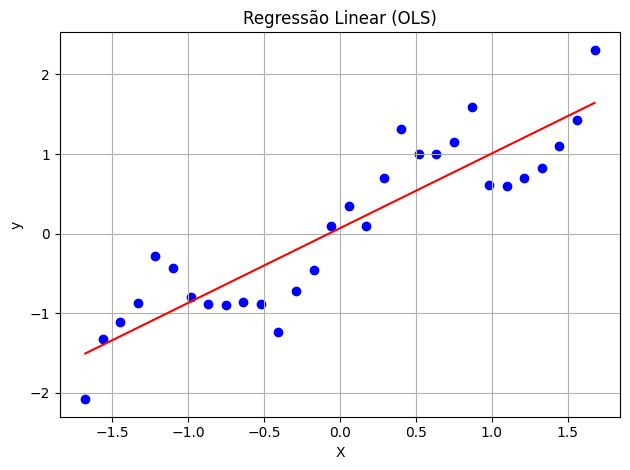

In [47]:
plot_reta(w, X_plot, 'OLS')

b) Apresente os parâmetros do modelo, o MSE e a curva de
aprendizagem obtidos pelo algoritmo GD (gradiente descendente). 
Plote a reta resultante sobre os dados.

In [52]:
def regressao_linear_gd(X: np.ndarray, y: np.ndarray, alpha: float=0.01, epochs: int=1000) -> Tuple[np.ndarray, List[float]]:
    """
    Implementação da regressão linear pelo método do gradiente descendente.
    :param X: matriz de atributos de entrada.
    :param y: vetor de resultados.
    :param alpha: taxa de aprendizado do modelo.
    :param epochs: total de épocas.
    :return: vetor de pesos e lista do EQM ao longo das épocas.
    """
    n: int = len(y)  # Número de entradas.
    eqms: List[float] = []  # Erros quadráticos médios.
    # Adiciona uma coluna de uns em X.
    X = np.hstack((np.ones((n, 1)), X))
    # Inicialização dos pesos.
    w: np.ndarray = np.zeros(X.shape[1])
    for _ in range(epochs):
        y_pred: np.ndarray = X @ w  # Cálculo de y predito.
        e: np.ndarray = y - y_pred  # Cálculo do erro.
        # Cálculo do erro quadrático médio.
        eqm: float = np.mean(e**2) 
        eqms.append(eqm)
        # Atualização dos parâmetros.
        w = w + (alpha/n) * (X.T @ e)
    return w, eqms

In [53]:
w, erros = regressao_linear_gd(X, y)

Parâmetros obtidos:

In [55]:
_ = [print(f'w{i}: {w[i]}') for i in range(len(w))]

w0: 0.06761500548818634
w1: 0.9400389507470148


Erro quadrático médio:

In [57]:
print(erros[-1])

0.213400903018601


Curva de aprendizagem:

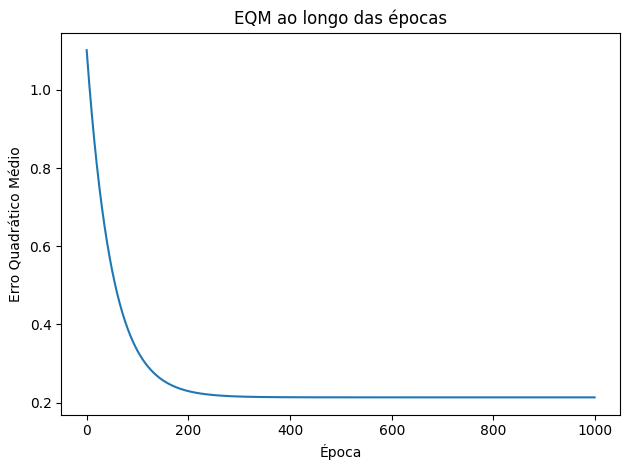

In [54]:
plot_eqm(erros)

Reta resultante:

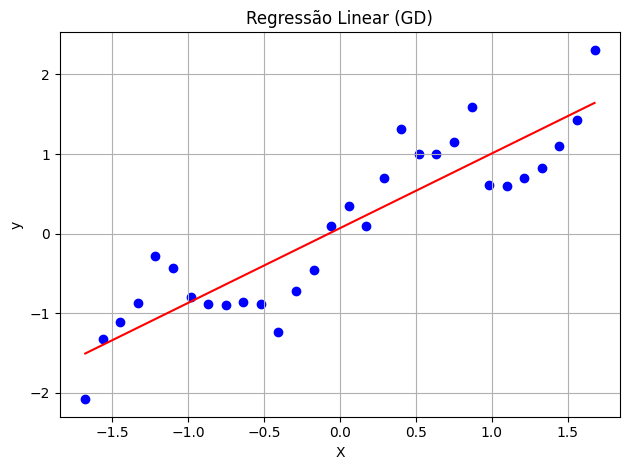

In [59]:
plot_reta(w, X_plot, 'GD')

In [28]:
def regressao_linear_gde(X: np.ndarray, y: np.ndarray, alpha: float=0.003, epochs: int=1000) -> Tuple[np.ndarray, List[float]]:
    """
    Implementação da regressão linear pelo método do gradiente descendente estocástico.
    :param X: matriz de atributos de entrada.
    :param y: vetor de resultados.
    :param alpha: taxa de aprendizado do modelo.
    :param epochs: total de épocas.
    :return: vetor de pesos e lista do EQM ao longo das épocas.
    """
    n: int = len(y)  # Número de entradas.
    eqms: List[float] = []  # Erros quadráticos médios.
    # Adiciona uma coluna de uns em X.
    X = np.hstack((np.ones((n, 1)), X))
    # Inicialização dos pesos.
    w: np.ndarray = np.zeros(X.shape[1])
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        # Embaralhamento de X e y.
        X = X[idx]
        y = y[idx]
        for xi, yi in zip(X, y):
            y_i_pred: np.ndarray = xi @ w  # Cálculo de yi predito.
            e_i: np.ndarray = yi - y_i_pred  # Cálculo do erro.
            # Atualização dos parâmetros.
            w += alpha * xi * e_i
        # Calculo dos erros totais
        y_pred: np.ndarray = X @ w  # Cálculo de y predito.
        e: np.ndarray = y - y_pred  # Cálculo do erro.
        # Cálculo do erro quadrático médio.
        eqm: float = np.mean(e**2) 
        eqms.append(eqm)
    return w, eqms

In [29]:
w, erros = regressao_linear_gde(X, y)

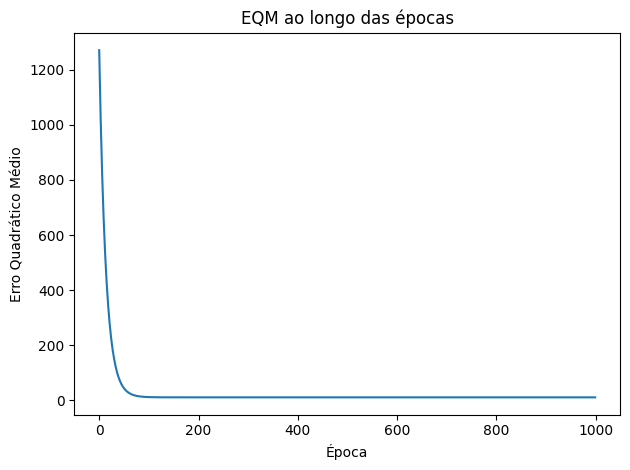

In [30]:
plt.plot(erros)
plt.title('EQM ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Erro Quadrático Médio')
plt.tight_layout()
plt.show()